##### This version involves further cleaning of data, which it to be used for the 2nd round of model training and testing (1st round is complete and can be found in the 'Code' folder named "Project_3_McNulty_Modeling_V1").

### List of Imports

In [235]:
from __future__ import print_function

In [1]:
import json
import pickle
import numpy as np 
import pandas as pd 
import seaborn as sns
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt
# from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


%matplotlib inline

/Users/liyuqiao/anaconda/envs/py3/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [237]:
pd.options.display.max_rows = 20

In [2]:
with open('../../../../raw_data/train.json', 'rb') as f:
    dict_ = json.load(f)

In [3]:
df = pd.DataFrame.from_dict(dict_)

In [4]:
df.cuisine.unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican', 'spanish',
       'italian', 'mexican', 'chinese', 'british', 'thai', 'vietnamese',
       'cajun_creole', 'brazilian', 'french', 'japanese', 'irish',
       'korean', 'moroccan', 'russian'], dtype=object)

In [21]:
df[df.cuisine == 'french'].iloc[2,2]

'orange,pumpkin_purée,marshmallow_creme,pecan,syrup,cinnamon,ginger,nutmeg,cream,'

In [6]:
# get rid of white spaces;
# replace space in between a phrase by "_";
# change all to lower-case letters 
df.ingredients = [','.join(i).replace(' ','_')
                  .lower().strip()+',' for i in df.ingredients]  

In [7]:
df.head(5)

,cuisine,id,ingredients
0,greek,10259,"romaine_lettuce,black_olives,grape_tomatoes,ga..."
1,southern_us,25693,"plain_flour,ground_pepper,salt,tomatoes,ground..."
2,filipino,20130,"eggs,pepper,salt,mayonaise,cooking_oil,green_c..."
3,indian,22213,"water,vegetable_oil,wheat,salt,"
4,indian,13162,"black_pepper,shallots,cornflour,cayenne_pepper..."


In [8]:
# an example on a greek cuisine 
df.ingredients[0]

'romaine_lettuce,black_olives,grape_tomatoes,garlic,pepper,purple_onion,seasoning,garbanzo_beans,feta_cheese_crumbles,'

In [9]:
key_ing = ['flour','egg','salt','oil','water','cilantro','garlic','milk'
           ,'pepper','tomato','corn','onion','butter','sugar','almond'
           ,'broth','chicken','beef','pork','sausage','rice','peanut'
           ,'cream','yeast','olives','lettuce','carrot','shrimp','walnut'
           ,'lemon','orange','ginger','allspice','turkey','cinnamon'
           ,'mint','parsley','thym','spinach','chive','dill','basil'
           ,'tarragon','coriander','parmesan','rosemary','lime','pecan'
           ,'peas','apple','vinegar','celery','cumin','turmeric','lamb'
           ,'cardamom','oregano','chili','cabbage','soy_sauce','mustard'
           ,'coconut_milk','raisins','nutmeg','bread','apricot','syrup'
           ,'cheddar','mozzarella','parmesan','romano','ricotta','jack'
           ,'squash','paprika','chocolate','potato','cocoa','sour_cream'
           ,'catfish','salmon','yogurt','sesame_seeds','vanilla'
           ,'feta_cheese']

def standardize_ingredient(row):
    """ This function returns a list of ingredients 
    with standardized names. """
    for i in row.split(','):
        for j in key_ing:
            if j in i:
                row = row.replace(i,j)
            else: 
                pass
    return row

In [10]:
df['ingredients'] = df['ingredients'].apply(standardize_ingredient)

In [11]:
df['ingredients'][0]

'lettuce,olives,tomato,garlic,pepper,onion,seasoning,garbanzo_beans,feta_cheese,'

In [197]:
top_10_ingredients = ['flour','egg','salt','oil','water'
                      ,'onion','pepper','sugar','tomato','garlic']
def remove_common_ingredient(row):
    """ This function returns a list of ingredients 
    after removing the top 10 common ingredients across cuisines. """
    for i in row.split(','):
        if i in top_10_ingredients:
            row = row.replace(i+',','')
        else: 
            pass
    return row

In [198]:
df['ingredients'] = df['ingredients'].apply(remove_common_ingredient)

In [199]:
df['ingredients'][0]

'lettuce,olives,seasoning,garbanzo_beans,feta_cheese,'

In [12]:
X = df['ingredients']
y = df['cuisine']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.30, random_state=7777)

In [14]:
print('The dimensinality of training features: ', X_train.shape)
print('The dimensinality of training target: ', y_train.shape)
print('The dimensinality of testing features: ', X_test.shape)
print('The dimensinality of testing target: ', y_test.shape)

The dimensinality of training features:  (27841,)
The dimensinality of training target:  (27841,)
The dimensinality of testing features:  (11933,)
The dimensinality of testing target:  (11933,)


### Build volcabulary for ingredients 

#### There are nearly 90k ingredients (with duplicates) out of 39774 cuisines in the dataset, so when building the vocabulary for ingredients, I wanted to set a reasonable threshold to get rid of terms that have a low document frequency. Given the size of the data and ingredients count, I decided to set the initial threshold at 50, meaning only ingredient terms appear more than 50 times across the dataset will be kept. 

In [15]:
X_train.head()

36277    dry_white_wine,corn,parsley,mustard,oil,garlic...
38444    chicken,milk,mint,cucumber,soy_sauce,lemon,car...
27216    mint,kirby_cucumbers,salt,pomegranate_seeds,ci...
11348    water,pork,cabbage,hominy,salt,lime,chili,cabb...
12930    shrimp,garlic,turmeric,fresh_curry_leaves,ging...
Name: ingredients, dtype: object

In [16]:
vec = CountVectorizer(min_df=50, 
                      tokenizer=lambda x: x.split(','),
                      analyzer = 'word')
count = vec.fit_transform(X_train).toarray()
igt_names = vec.get_feature_names()

##### Pickle countvectorizer for later use 

In [205]:
# with open('../../Data/countvectorizer.pickle', 'wb') as handle: 
#     pickle.dump(vec, handle, pickle.HIGHEST_PROTOCOL)

In [206]:
X_test = vec.transform(X_test)

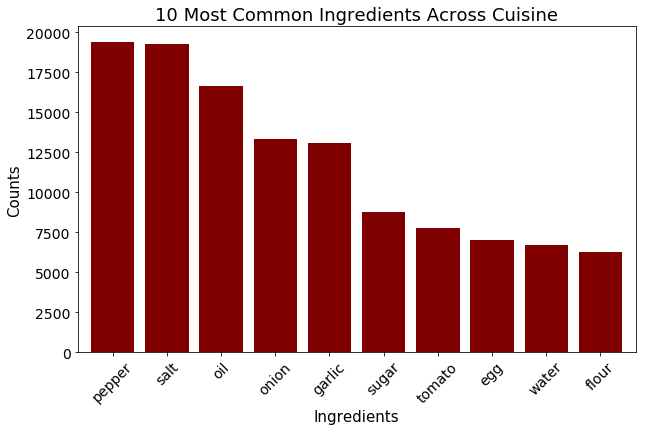

In [18]:
# igt_frequency = pd.Series(count.sum(axis=0),index = igt_names
#                          ).sort_values(ascending=False)
# ax = igt_frequency[1:11
#               ].plot(kind='bar'
#                      ,color='maroon'
#                      , figsize=(10,6)
#                      , width=.8
#                      , fontsize=14
#                      , rot=45
#                      ,title='10 Most Common Ingredients Across Cuisine')
# ax.title.set_size(18)
# plt.xlabel('Ingredients',fontsize=15)
# plt.ylabel('Counts', fontsize=15)

# plt.savefig('../../Visuals/mostcommonigt.png', dpi=200, bbox_inches = 'tight')

In [208]:
counts = np.clip(count, 0, 1, out=count)
counts_reshaped = counts.reshape(len(X_train),len(igt_names))
X_train = pd.DataFrame(counts_reshaped)
X_train.columns = igt_names

In [209]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27841 entries, 0 to 27840
Columns: 337 entries,  to zucchini
dtypes: int64(337)
memory usage: 71.6 MB


In [210]:
X_train.head(2)

,,_drain,_soften,adobo_sauce,agave_nectar,allspice,almond,amchur,ancho_powder,anchovy_fillets,...,walnut,white_wine,whole_cloves,whole_wheat_tortillas,wonton_wrappers,worcestershire_sauce,yeast,yoghurt,yogurt,zucchini
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [211]:
X_train.columns

Index(['', '_drain', '_soften', 'adobo_sauce', 'agave_nectar', 'allspice',
       'almond', 'amchur', 'ancho_powder', 'anchovy_fillets',
       ...
       'walnut', 'white_wine', 'whole_cloves', 'whole_wheat_tortillas',
       'wonton_wrappers', 'worcestershire_sauce', 'yeast', 'yoghurt', 'yogurt',
       'zucchini'],
      dtype='object', length=337)

##### Pickle the cleaned dataframe & a small subset as a sample 

In [212]:
df2_cleaned_sample = X_train[0:50]

In [213]:
df2_cleaned_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Columns: 337 entries,  to zucchini
dtypes: int64(337)
memory usage: 131.7 KB


In [214]:
# with open('../../Data/train_standardized.pickle', 'wb') as handle: 
#     pickle.dump(X_train, handle, pickle.HIGHEST_PROTOCOL)

In [215]:
# with open('../../Data/test_transformed.pickle', 'wb') as handle: 
#     pickle.dump(X_test, handle, pickle.HIGHEST_PROTOCOL)

In [216]:
# with open('../../Data/train_target.pickle', 'wb') as handle: 
#     pickle.dump(y_train, handle, pickle.HIGHEST_PROTOCOL)

In [217]:
# with open('../../Data/test_target.pickle', 'wb') as handle: 
#     pickle.dump(y_test, handle, pickle.HIGHEST_PROTOCOL)

In [218]:
# with open('../../Data/standardized_sample.pickle', 'wb') as handle: 
#     pickle.dump(df2_cleaned_sample, handle, pickle.HIGHEST_PROTOCOL)

## More Visuals 
#### Top 3 ingredients for each cuisine 

In [219]:
df_igt = df['ingredients']
df_igt.head()

0    lettuce,olives,seasoning,garbanzo_beans,feta_c...
1                                thym,green_corn,milk,
2    mayonaise,chili,chicken,soy_sauce,butter,chicken,
3                                               wheat,
4    shallots,milk,butter,lemon,chili,passata,cumin...
Name: ingredients, dtype: object

In [220]:
df.head()

,cuisine,id,ingredients
0,greek,10259,"lettuce,olives,seasoning,garbanzo_beans,feta_c..."
1,southern_us,25693,"thym,green_corn,milk,"
2,filipino,20130,"mayonaise,chili,chicken,soy_sauce,butter,chicken,"
3,indian,22213,"wheat,"
4,indian,13162,"shallots,milk,butter,lemon,chili,passata,cumin..."


##### Get rid of more common ingredients to have meaningful insight on unique top ingredients for each cuisine

In [221]:
common_ingredients = ['flour','egg','oil','water','cilantro','salt'
                      ,'garlic','milk','syrup','olives','lettuce','butter'
                      ,'pepper','tomato','corn','onion','baking_soda'
                      ,'sugar','almond','broth','chicken','beef','pecan'
                      ,'pork','sausage','rice','peanut','cream','lime'
                      ,'yeast','olives','lettuce','carrot','shrimp'
                      ,'walnut','lemon','orange','ginger','allspice'
                      ,'turkey','cinnamon','mint','parsley','thym','apple'
                      ,'spinach','chive','dill','basil','mustard','ice'
                      ,'coconut_milk','raisins','nutmeg','bread','celery'
                      ,'apricot','cheddar','jack','squash','chocolate'
                      ,'potato','cocoa','sour_cream','vinegar','catfish'
                      ,'salmon','yogurt','sesame_seeds','_drain','cabbage'
                      ,'_soften','vanilla','salt','baking_powder'
                      ,'cucumber']
def remove_more_common_ingredient(row,ingredients_list):
    """ This function returns a list of ingredients 
    after removing the above common ingredients across cuisines. """
    for i in row.split(','):
        if i in ingredients_list:
            row = row.replace(i+',','')
        else: 
            pass
    return row

In [222]:
df_igt = df_igt.apply(remove_more_common_ingredient
                      ,ingredients_list=common_ingredients)
df_igt.head()

0                seasoning,garbanzo_beans,feta_cheese,
1                                          green_corn,
2                           mayonaise,chili,soy_sauce,
3                                               wheat,
4    shallots,chili,passata,cumin,garam_masala,bay_...
Name: ingredients, dtype: object

In [223]:
vec1 = CountVectorizer(min_df=50, tokenizer=lambda x: x.split(',')
                      ,analyzer = 'word')
count1 = vec1.fit_transform(df_igt).toarray()
igt_names1 = vec1.get_feature_names()
counts1 = np.clip(count1, 0, 1, out=count1)
counts_reshaped1 = counts1.reshape(len(df_igt),len(igt_names1))
df_igt = pd.DataFrame(counts_reshaped1)
df_igt.columns = igt_names1

In [224]:
df_vectorized = pd.concat([df, df_igt],axis=1)
df_vectorized.drop(['ingredients','id',''],axis=1,inplace=True)
df_vectorized.head()

,cuisine,adobo_sauce,agave_nectar,amchur,anaheim_chile,ancho_powder,anchovies,anchovy_fillets,anchovy_paste,angel_hair,...,white_miso,white_mushrooms,white_wine,whole_cloves,whole_wheat_tortillas,wine,wonton_wrappers,worcestershire_sauce,yoghurt,zucchini
0,greek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,southern_us,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,filipino,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,indian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,indian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [225]:
igt_by_cuisine = df_vectorized.groupby('cuisine').sum()

In [226]:
nlargest = 3
order = np.argsort(-igt_by_cuisine.values, axis=1)[:, :nlargest]
igt_by_cuisine = pd.DataFrame(igt_by_cuisine.columns[order], 
                      columns=['top{}'.format(i) for i in 
                               range(1, nlargest+1)],
                      index=igt_by_cuisine.index)

In [227]:
igt_by_cuisine

,top1,top2,top3
cuisine,,,
brazilian,cachaca,black_beans,chili
british,worcestershire_sauce,peas,strawberries
cajun_creole,cajun_seasoning,paprika,oregano
chinese,soy_sauce,scallions,oyster_sauce
filipino,soy_sauce,bay_leaves,fish_sauce
french,shallots,dry_white_wine,cooking_spray
greek,feta_cheese,oregano,lamb
indian,cumin,chili,coriander
irish,cooking_spray,leeks,lamb


In [228]:
# with open('../../Data/top3ingredients.pickle', 'wb') as handle: 
#     pickle.dump(igt_by_cuisine, handle, pickle.HIGHEST_PROTOCOL)